<font size=4>Compare with LSTM model,CNN+LSTM is excellent.:https://www.kaggle.com/code/yunsuxiaozi/lstm-predict-mean-temp</font>


In [1]:
import pandas as pd#导入csv文件的库
import numpy as np#进行矩阵运算的库
import matplotlib.pyplot as plt#导入强大的绘图库
import torch#一个深度学习的库Pytorch
import torch.nn as nn#neural network,神经网络
import torch.optim as optim#一个实现了各种优化算法的库
import warnings#避免一些可以忽略的报错
warnings.filterwarnings('ignore')#filterwarnings()方法是用于设置警告过滤器的方法，它可以控制警告信息的输出方式和级别.

In [2]:
#设置随机种子
import random
torch.backends.cudnn.deterministic = True#将cudnn框架中的随机数生成器设为确定性模式
torch.backends.cudnn.benchmark = False#关闭CuDNN框架的自动寻找最优卷积算法的功能，以避免不同的算法对结果产生影响
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

In [7]:
train_df=pd.read_csv("/home/dzhang/wudan/machine_learning/LSTM/data/train_data.csv")
train_df.drop('instant', axis=1, inplace=True)  # 删除序号
train_df.drop('dteday', axis=1, inplace=True)  # 删除日期
train_df.drop('atemp', axis=1, inplace=True)  # 删除日期
train_df.drop('casual', axis=1, inplace=True)  # 删除日期
train_df.drop('registered', axis=1, inplace=True)  # 删除日期
print(f"len(train_df):{len(train_df)}")
train_df.head()

len(train_df):15216


,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt
0,1,0,1,0,0,6,0,1,0.24,0.81,0.0,16
1,1,0,1,1,0,6,0,1,0.22,0.80,0.0,40
2,1,0,1,2,0,6,0,1,0.22,0.80,0.0,32
3,1,0,1,3,0,6,0,1,0.24,0.75,0.0,13
4,1,0,1,4,0,6,0,1,0.24,0.75,0.0,1


In [37]:
meantemp=train_df['cnt'].values
print(f"len(cnt):{len(meantemp)}")

len(cnt):15216


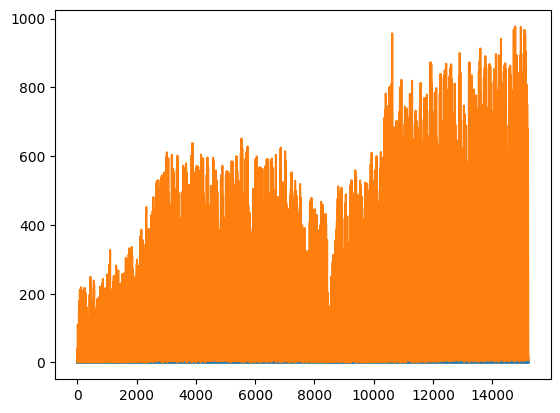

In [31]:
plt.plot([i for i in range(len(meantemp))],meantemp)

In [36]:
from sklearn.preprocessing import MinMaxScaler
# 创建MinMaxScaler对象
scaler = MinMaxScaler()
# 将数据进行归一化
meantemp = scaler.fit_transform(meantemp.reshape(-1,1))
meantemp.shape

(182592, 1)

In [33]:
def create_sequences(data, input_length, output_length):
        X, y = [], []
        for i in range(len(data) - input_length - output_length + 1):
            X.append(data[i:i + input_length, :-1])  # 使用除cnt之外的所有特征
            y.append(data[i + input_length:i + input_length + output_length, -1])  # cnt是最后一列
        return np.array(X), np.array(y)

In [39]:
dataX,datay=create_sequences(train_df.values,96,96)
print(f"dataX.shape:{dataX.shape},datay.shape:{datay.shape}")

dataX.shape:(15025, 96, 11),datay.shape:(15025, 96)


In [40]:
#划分训练集和测试集的函数
def train_test_split(dataX,datay,shuffle=True,percentage=0.8):
    """
    将训练数据X和标签y以numpy.array数组的形式传入
    划分的比例定为训练集:测试集=8:2
    """
    if shuffle:
        random_num=[index for index in range(len(dataX))]
        np.random.shuffle(random_num)
        dataX=dataX[random_num]
        datay=datay[random_num]
    split_num=int(len(dataX)*percentage)
    train_X=dataX[:split_num]
    train_y=datay[:split_num]
    test_X=dataX[split_num:]
    test_y=datay[split_num:]
    return train_X,train_y,test_X,test_y

In [41]:
train_X,train_y,test_X,test_y=train_test_split(dataX,datay,shuffle=False,percentage=0.8)
print(f"train_X.shape:{train_X.shape},test_X.shape:{test_X.shape}")

train_X.shape:(12020, 96, 11),test_X.shape:(3005, 96, 11)


In [42]:
X_train,y_train=train_X,train_y

In [47]:
# 定义CNN+LSTM模型类
class CNN_LSTM(nn.Module):
    def __init__(self, conv_input,input_size, hidden_size, num_layers, output_size):
        super(CNN_LSTM,self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.conv=nn.Conv1d(conv_input,conv_input,1)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x=self.conv(x)
        h0 = torch.zeros(self.num_layers,x.size(0), self.hidden_size) # 初始化隐藏状态h0
        c0 = torch.zeros(self.num_layers,x.size(0), self.hidden_size)  # 初始化记忆状态c0
        #print(f"x.shape:{x.shape},h0.shape:{h0.shape},c0.shape:{c0.shape}")
        out, _ = self.lstm(x, (h0, c0))  # LSTM前向传播
        out = self.fc(out[:, -1, :])  # 取最后一个时间步的输出作为预测结果
        return out

In [51]:
%%time 
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
test_X1=torch.Tensor(test_X)
test_y1=torch.Tensor(test_y)

# 定义输入、隐藏状态和输出维度
input_size = 11  # 输入特征维度
conv_input=96
hidden_size = 96  # LSTM隐藏状态维度
num_layers = 5  # LSTM层数
output_size = 96  # 输出维度（预测目标维度）

# 创建CNN_LSTM模型实例
model =CNN_LSTM(conv_input,input_size, hidden_size, num_layers, output_size)
model.to(device)
#训练周期为500次
num_epochs=500
batch_size=64#一次训练的数量
#优化器
optimizer=optim.Adam(model.parameters(),lr=0.0001,betas=(0.5,0.999))
#损失函数
criterion=nn.MSELoss()

train_losses=[]
test_losses=[]

print(f"start")

for epoch in range(num_epochs):
    
    random_num=[i for i in range(len(train_X))]
    np.random.shuffle(random_num)
    
    train_X=train_X[random_num]
    train_y=train_y[random_num]
    
    train_X1=torch.Tensor(train_X[:batch_size])
    train_y1=torch.Tensor(train_y[:batch_size])
    
    #训练
    model.train()
    #将梯度清空
    optimizer.zero_grad()
    #将数据放进去训练
    train_X1.to(device)
    train_y1.to(device)
    test_X1.to(device)
    test_y1.to(device)
    output=model(train_X1)
    #计算每次的损失函数
    train_loss=criterion(output,train_y1)
    #反向传播
    train_loss.backward()
    #优化器进行优化(梯度下降,降低误差)
    optimizer.step()
    
    if epoch%50==0:
        model.eval()
        with torch.no_grad():
            output=model(test_X1)
            test_loss=criterion(output,test_y1)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        print(f"epoch:{epoch},train_loss:{train_loss},test_loss:{test_loss}")

start


RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [14]:
def mse(pred_y,true_y):
    return np.mean((pred_y-true_y) ** 2)

In [15]:
train_X1=torch.Tensor(X_train)
train_pred=model(train_X1).detach().numpy()
test_pred=model(test_X1).detach().numpy()
pred_y=np.concatenate((train_pred,test_pred))
pred_y=scaler.inverse_transform(pred_y).T[0]
true_y=np.concatenate((y_train,test_y))
true_y=scaler.inverse_transform(true_y).T[0]
print(f"mse(pred_y,true_y):{mse(pred_y,true_y)}")

mse(pred_y,true_y):5.53722039981887


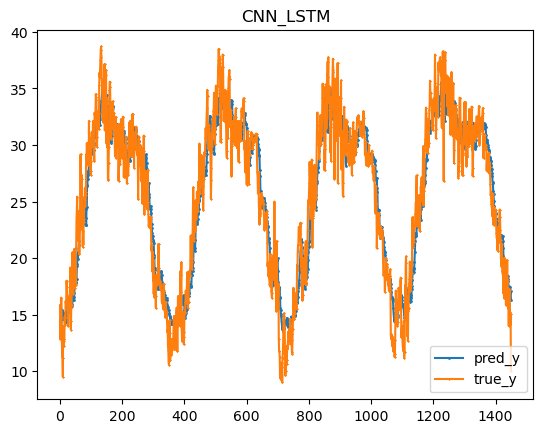

In [16]:
plt.title("CNN_LSTM")
x=[i for i in range(len(true_y))]
plt.plot(x,pred_y,marker="o",markersize=1,label="pred_y")
plt.plot(x,true_y,marker="x",markersize=1,label="true_y")
plt.legend()
plt.show()